In [1]:
#import os
#import numpy as np 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit
# import torch
# from torch import nn
# from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import sys
sys.path.insert(0, "../code")   
from model_utils import train


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
# load
df = pd.read_excel("../output/data/scaled_train_nonoverlap_top_10_store_item_X_y.xlsx")
df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
2,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
3,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
4,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


In [4]:
df.dtypes

date                 datetime64[ns]
store_item                   object
store                         int64
item                          int64
sales_day_1                 float64
sales_day_2                 float64
sales_day_3                 float64
sales_day_4                 float64
sales_day_5                 float64
sales_day_6                 float64
sales_day_7                 float64
store_med_day_1             float64
store_med_day_2             float64
store_med_day_3             float64
store_med_day_4             float64
store_med_day_5             float64
store_med_day_6             float64
store_med_day_7             float64
item_med_day_1              float64
item_med_day_2              float64
item_med_day_3              float64
item_med_day_4              float64
item_med_day_5              float64
item_med_day_6              float64
item_med_day_7              float64
y_sales_day_1               float64
y_sales_day_2               float64
y_sales_day_3               

In [5]:
df.columns

Index(['date', 'store_item', 'store', 'item', 'sales_day_1', 'sales_day_2',
       'sales_day_3', 'sales_day_4', 'sales_day_5', 'sales_day_6',
       'sales_day_7', 'store_med_day_1', 'store_med_day_2', 'store_med_day_3',
       'store_med_day_4', 'store_med_day_5', 'store_med_day_6',
       'store_med_day_7', 'item_med_day_1', 'item_med_day_2', 'item_med_day_3',
       'item_med_day_4', 'item_med_day_5', 'item_med_day_6', 'item_med_day_7',
       'y_sales_day_1', 'y_sales_day_2', 'y_sales_day_3', 'y_sales_day_4',
       'y_sales_day_5', 'y_sales_day_6', 'y_sales_day_7', 'y_store_med_day_1',
       'y_store_med_day_2', 'y_store_med_day_3', 'y_store_med_day_4',
       'y_store_med_day_5', 'y_store_med_day_6', 'y_store_med_day_7',
       'y_item_med_day_1', 'y_item_med_day_2', 'y_item_med_day_3',
       'y_item_med_day_4', 'y_item_med_day_5', 'y_item_med_day_6',
       'y_item_med_day_7'],
      dtype='object')

In [6]:
feature_cols = (
    [f"sales_day_{i}"     for i in range(1, 8)]  # 7 cols
  + [f"store_med_day_{i}" for i in range(1, 8)]  # 7 cols
  + [f"item_med_day_{i}"  for i in range(1, 8)]  # 7 cols
)
label_cols = (
    [f"y_sales_day_{i}"     for i in range(1,8)]
  + [f"y_store_med_day_{i}" for i in range(1,8)]
  + [f"y_item_med_day_{i}"  for i in range(1,8)]
)
# # … shift & drop to build X, y …
df = df.dropna(subset=[f'y_{c}' for c in feature_cols]).reset_index(drop=True)
df.head()

,date,store_item,store,item,sales_day_1,sales_day_2,sales_day_3,sales_day_4,sales_day_5,sales_day_6,...,y_store_med_day_5,y_store_med_day_6,y_store_med_day_7,y_item_med_day_1,y_item_med_day_2,y_item_med_day_3,y_item_med_day_4,y_item_med_day_5,y_item_med_day_6,y_item_med_day_7
0,2013-01-07,3_1047679,3,1047679,0.458730,0.073355,0.098931,0.201942,0.392058,0.811775,...,0.248855,0.293631,0.37344,0.655298,0.424149,0.176024,0.202652,0.437086,0.675746,0.711467
1,2013-01-07,3_114790,3,114790,0.022222,0.002373,0.003231,0.006214,0.010830,0.017841,...,0.248855,0.293631,0.37344,0.018270,0.018576,0.040971,0.030303,0.027815,0.068742,0.069051
2,2013-01-07,3_305229,3,305229,0.070635,0.012513,0.020134,0.019029,0.080144,0.075825,...,0.248855,0.293631,0.37344,0.060901,0.074303,0.110774,0.056818,0.047682,0.089494,0.123305
3,2013-01-07,3_314384,3,314384,0.084127,0.014671,0.020880,0.021359,0.051986,0.080285,...,0.248855,0.293631,0.37344,0.123021,0.160991,0.201821,0.155303,0.156291,0.280156,0.314427
4,2013-01-07,3_364606,3,364606,0.099206,0.022654,0.026597,0.028738,0.062094,0.116860,...,0.248855,0.293631,0.37344,0.210719,0.243034,0.295903,0.301136,0.196026,0.315175,0.383477


In [7]:
weights_df= pd.read_excel("../output/data/top_10_item_weights.xlsx")

In [8]:
weights_df

,item,weight
0,114790,1.00
1,305229,1.00
2,314384,1.00
3,364606,1.00
4,502331,1.25
5,567623,1.00
6,581078,1.00
7,582864,1.25
8,584028,1.25
9,1047679,1.00


In [16]:
hist_df, summary_df, models_dict = train(
    df            = df,
    weights_df    = weights_df,
    feature_cols  = feature_cols,
    label_cols    = label_cols,
    item_col      = "item",
    train_frac    = 0.8,
    batch_size    = 32,
    lr            = 1e-3,
    epochs        = 50,
    seed          = 2025,
    model_dir     = "../output/models/"
)

[3_1047679] Epoch 1/50 — train 0.8259, test 0.8552
[3_1047679] Epoch 2/50 — train 0.7692, test 0.8003
[3_1047679] Epoch 3/50 — train 0.7106, test 0.7408
[3_1047679] Epoch 4/50 — train 0.6477, test 0.6760
[3_1047679] Epoch 5/50 — train 0.5821, test 0.6091
[3_1047679] Epoch 6/50 — train 0.5210, test 0.5479
[3_1047679] Epoch 7/50 — train 0.4738, test 0.5001
[3_1047679] Epoch 8/50 — train 0.4443, test 0.4677
[3_1047679] Epoch 9/50 — train 0.4274, test 0.4472
[3_1047679] Epoch 10/50 — train 0.4165, test 0.4353
[3_1047679] Epoch 11/50 — train 0.4088, test 0.4297
[3_1047679] Epoch 12/50 — train 0.4039, test 0.4276
[3_1047679] Epoch 13/50 — train 0.4007, test 0.4267
[3_1047679] Epoch 14/50 — train 0.3984, test 0.4257
[3_1047679] Epoch 15/50 — train 0.3966, test 0.4245
[3_1047679] Epoch 16/50 — train 0.3950, test 0.4233
[3_1047679] Epoch 17/50 — train 0.3936, test 0.4223
[3_1047679] Epoch 18/50 — train 0.3923, test 0.4215
[3_1047679] Epoch 19/50 — train 0.3909, test 0.4210
[3_1047679] Epoch 20/

In [17]:
hist_df.head(3)


,store_item,epoch,train_loss,test_loss
0,3_1047679,1,0.825924,0.855200
1,3_1047679,2,0.769211,0.800326
2,3_1047679,3,0.710638,0.740825


In [18]:
summary_df.head(3)

,store_item,final_train_loss,final_test_loss
0,3_1047679,0.343407,0.411792
1,3_114790,0.176714,0.265950
2,3_305229,0.189679,0.198183


In [19]:


def plot_loss_per_sid(hist_df, sid, fn):
    """
    Plot train and test loss vs. epoch for a given store_item (sid),
    save to file `fn`.
    """
    df = hist_df[hist_df["store_item"] == sid].sort_values("epoch")
    if df.empty:
        raise ValueError(f"No data found for store_item = {sid!r}")

    fig, ax = plt.subplots(figsize=(12, 5))

    # plot
    ax.plot(df["epoch"], df["train_loss"], marker="o", label="Train Loss")
    ax.plot(df["epoch"], df["test_loss"],  marker="o", label="Validation Loss")

    # titles & labels
    ax.set_title(f"Loss Curves for {sid}", fontsize=24, fontweight="bold")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    # ticks exactly at each epoch
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(df["epoch"].min(), df["epoch"].max())  # clamp x-axis

    # y-axis ticks
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))

    # grid, legend
    ax.grid(True, which="major", linestyle="--", alpha=0.5)
    ax.legend()

    # tick styling
    ax.tick_params(axis='x', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.tick_params(axis='y', which='major', length=6)
    ax.tick_params(axis='y', which='minor', length=4)

    plt.tight_layout(pad=2)
    plt.savefig(fn, dpi=300)
    plt.show()
    plt.close(fig)


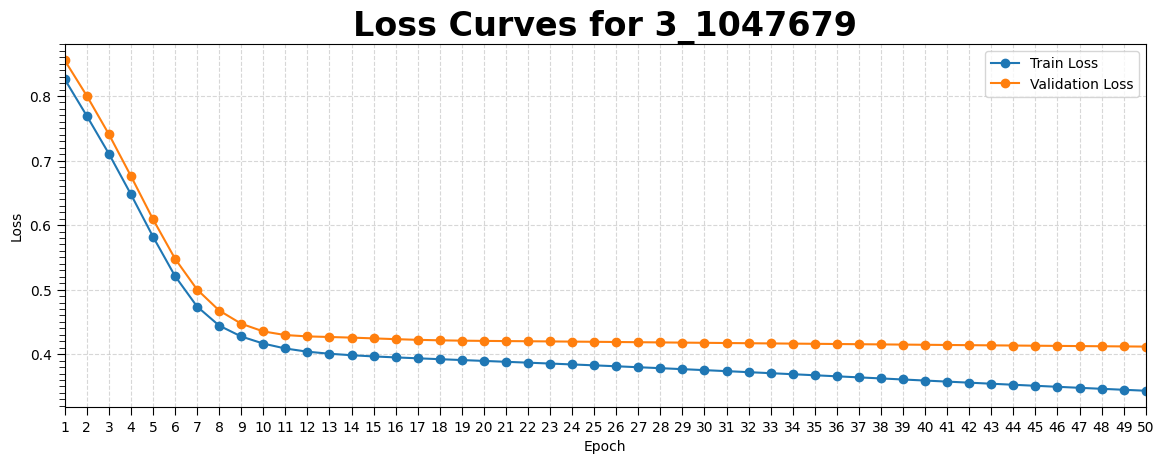

In [20]:
# to plot a single sid:
sid = "3_1047679"
plot_loss_per_sid(hist_df, sid=sid, fn=f"../output/figures/loss_curves_{sid}.tiff")

# # if you want to loop over all sids:
# for sid in hist_df["store_item"].unique():
#     plot_loss_per_sid(hist_df, sid)


In [21]:

def plot_all_sids_losses(hist_df, overall_title=None, fn=None):
    sids   = hist_df["store_item"].unique()
    epochs = sorted(hist_df["epoch"].unique())
    
    fig, (ax_tr, ax_te) = plt.subplots(2,1, figsize=(12,8), sharex=True)

    # — Train Loss —
    for sid in sids:
        df_sid = hist_df[hist_df["store_item"]==sid]
        ax_tr.plot(df_sid["epoch"], df_sid["train_loss"],
                   marker="o", linewidth=1, label=sid)
    ax_tr.set_title("Train Loss by Epoch", fontsize=16, fontweight="bold")
    ax_tr.set_ylabel("Train Loss")
    ax_tr.grid(True, linestyle="--", alpha=0.5)
    #ax_tr.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02,1), loc="best")

    # — Validation Loss —
    for sid in sids:
        df_sid = hist_df[hist_df["store_item"]==sid]
        ax_te.plot(df_sid["epoch"], df_sid["test_loss"],
                   marker="o", linewidth=1, label=sid)
    ax_te.set_title("Validation Loss by Epoch", fontsize=16, fontweight="bold")
    ax_te.set_xlabel("Epoch")
    ax_te.set_ylabel("Validation Loss")
    ax_te.grid(True, linestyle="--", alpha=0.5)
    #ax_te.legend(fontsize="small", ncol=2, bbox_to_anchor=(1.02,1), loc="best")

    # — Ticks every epoch, bigger & bold —
    for ax in (ax_tr, ax_te):
        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.set_xlim(hist_df['epoch'].min(), hist_df['epoch'].max())  # Clamp x-axis
        # enlarge & bold tick labels
        for lbl in ax.get_xticklabels(which="major"):
            lbl.set_fontsize(10)
            lbl.set_fontweight("bold")
        for lbl in ax.get_yticklabels(which="major"):
            lbl.set_fontsize(10)
            lbl.set_fontweight("bold")

    # — Add overall title if provided —
    if overall_title:
        fig.suptitle(overall_title, fontsize=20, fontweight="bold")
        # tighten_layout will by default overlap the suptitle, so add this:
        plt.subplots_adjust(top=0.90)
        
    plt.tight_layout(pad=3)
    if fn:
        plt.savefig(fn, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

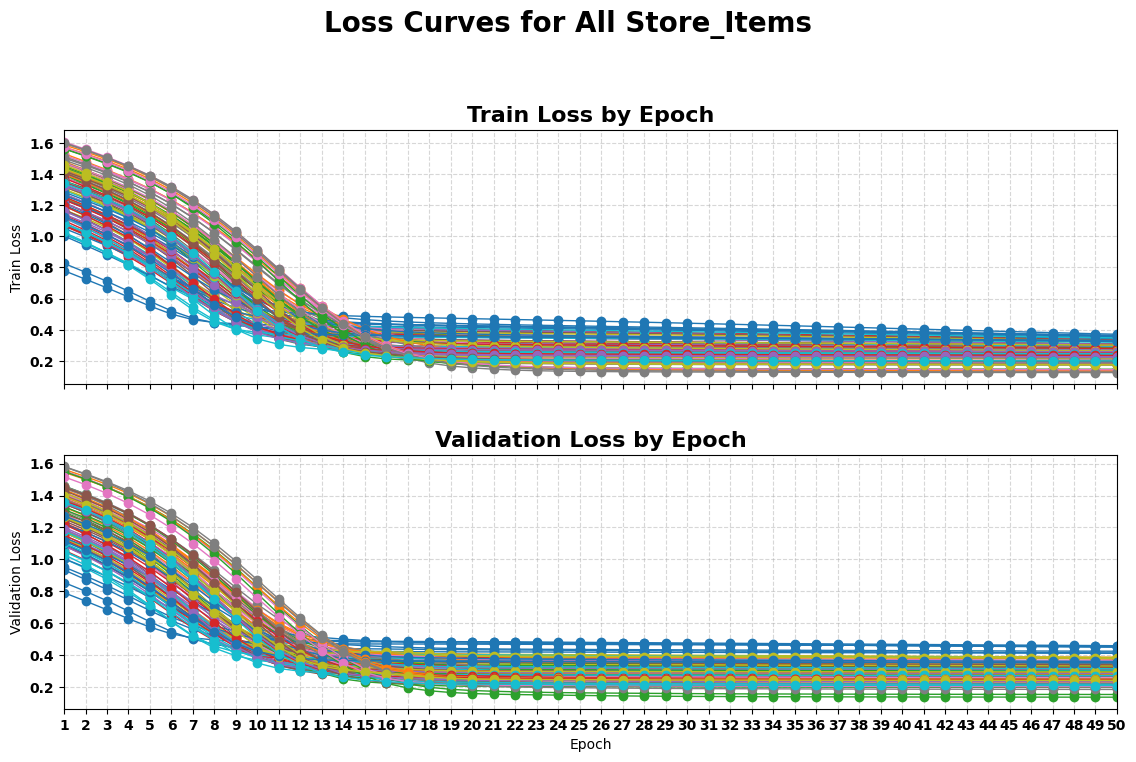

In [22]:
# Example usage:
plot_all_sids_losses(hist_df, 
                     overall_title="Loss Curves for All Store_Items",
fn=f"../output/figures/all_sids_loss_curves_.tiff")
